<a href="https://colab.research.google.com/github/aparajitverma/MACHINE-LEARNING/blob/master/Customer_Tickets_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import string




df = pd.read_csv(r'/content/dataset-tickets-multi-lang-4-20k.csv')
df.head

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())



First few rows of the dataset:
                                             subject  \
0  Unvorhergesehener Absturz der Datenanalyse-Pla...   
1                           Customer Support Inquiry   
2                      Data Analytics for Investment   
3                 Krankenhaus-Dienstleistung-Problem   
4                                           Security   

                                                body  \
0  Die Datenanalyse-Plattform brach unerwartet ab...   
1  Seeking information on digital strategies that...   
2  I am contacting you to request information on ...   
3  Ein Medien-Daten-Sperrverhalten trat aufgrund ...   
4  Dear Customer Support, I am reaching out to in...   

                                              answer      type  \
0  Ich werde Ihnen bei der Lösung des Problems he...  Incident   
1  We offer a variety of digital strategies and s...   Request   
2  I am here to assist you with data analytics to...   Request   
3  Zurück zur E-Mail-Beschwerde

# EXPLORATORY DATA ANALYSIS

In [ ]:


# EDA
print("\nEDA and Visualization")
print("\nSummary statistics:")
print(df.describe(include='all'))


EDA and Visualization

Summary statistics:
       subject   body                                             answer  \
count    20000  20000                                              19996   
unique   18540  19999                                              19996   
top                    Ich werde Ihnen bei der Lösung des Problems he...   
freq      1461      2                                                  1   
mean       NaN    NaN                                                NaN   
std        NaN    NaN                                                NaN   
min        NaN    NaN                                                NaN   
25%        NaN    NaN                                                NaN   
50%        NaN    NaN                                                NaN   
75%        NaN    NaN                                                NaN   
max        NaN    NaN                                                NaN   

            type              queue priorit

<ipython-input-30-d62247db10be>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['queue'], order=df['queue'].value_counts().index, palette="coolwarm")


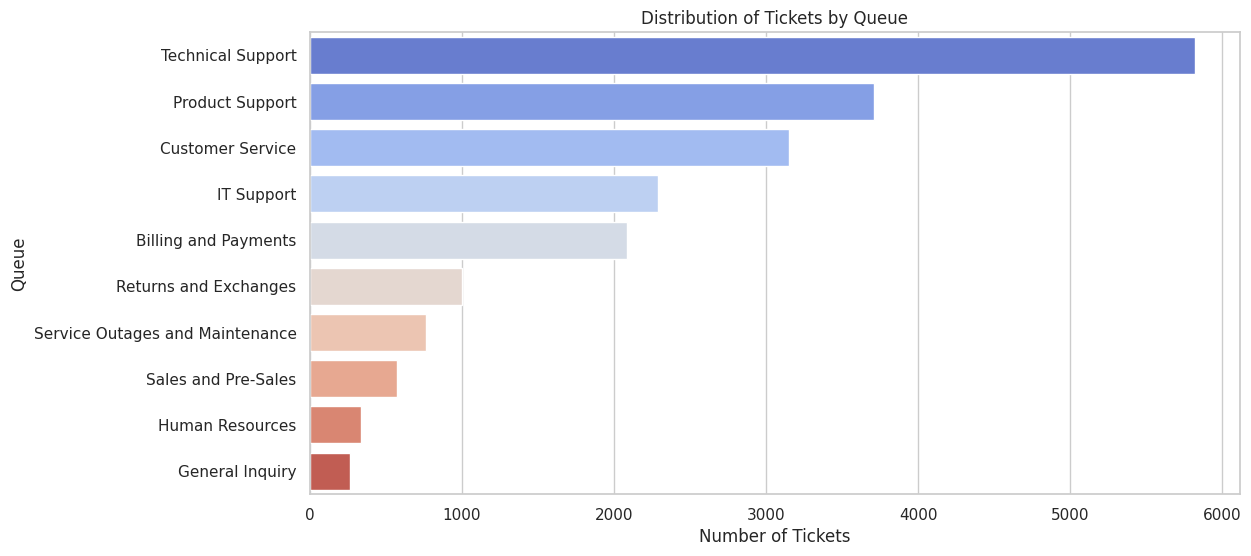

In [ ]:
# Set style
sns.set(style="whitegrid")

# 1. Ticket Distribution by Queue
plt.figure(figsize=(12, 6))
sns.countplot(y=df['queue'], order=df['queue'].value_counts().index, palette="coolwarm")
plt.title("Distribution of Tickets by Queue")
plt.xlabel("Number of Tickets")
plt.ylabel("Queue")
plt.show()

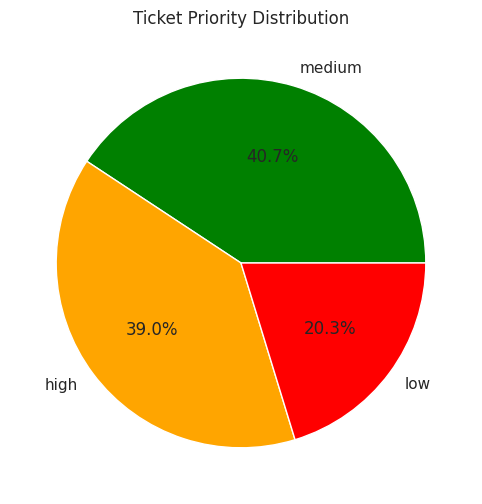

In [ ]:
# 2. Ticket Priority Distribution
plt.figure(figsize=(8, 6))
df['priority'].value_counts().plot.pie(autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title("Ticket Priority Distribution")
plt.ylabel("")
plt.show()

<ipython-input-5-44a28a56836e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['language'], palette="Set2")


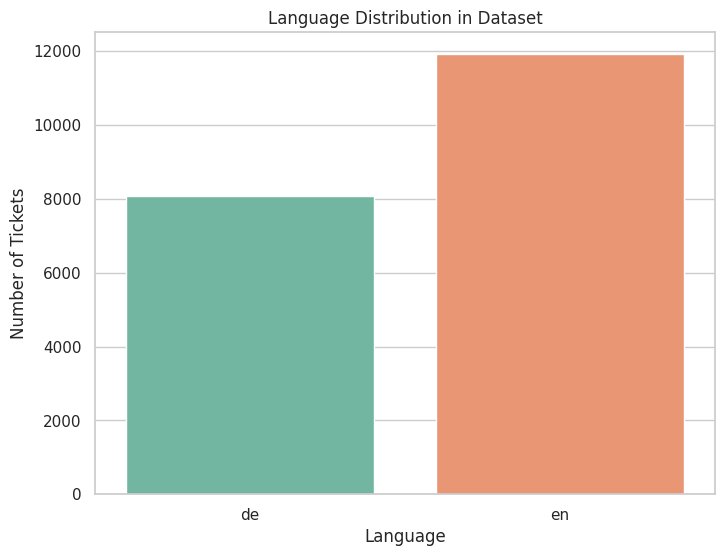

In [ ]:

# 3. Language Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=df['language'], palette="Set2")
plt.title("Language Distribution in Dataset")
plt.xlabel("Language")
plt.ylabel("Number of Tickets")
plt.show()


<ipython-input-43-9d7bd7c3b58c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['type'], order=df['type'].value_counts().index, palette="viridis")


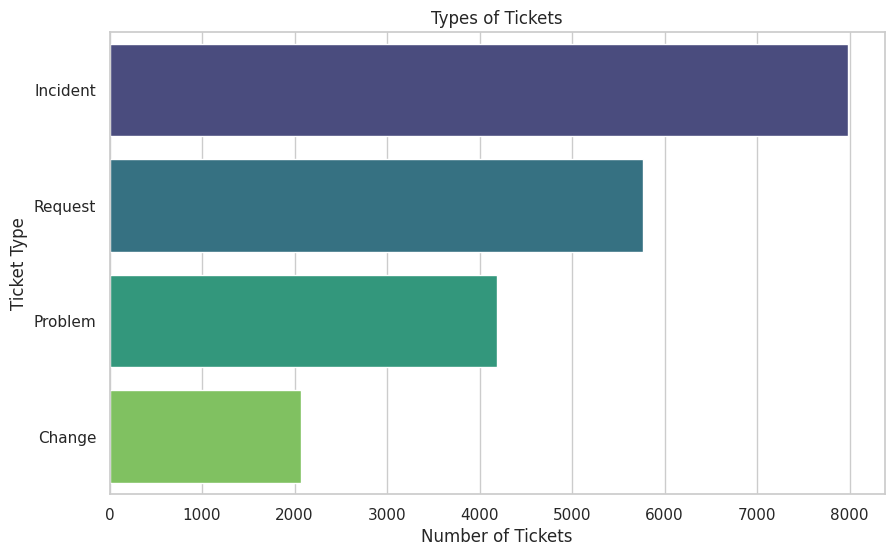

In [ ]:
# 4. Type of Tickets
plt.figure(figsize=(10, 6))
sns.countplot(y=df['type'], order=df['type'].value_counts().index, palette="viridis")
plt.title("Types of Tickets")
plt.xlabel("Number of Tickets")
plt.ylabel("Ticket Type")
plt.show()

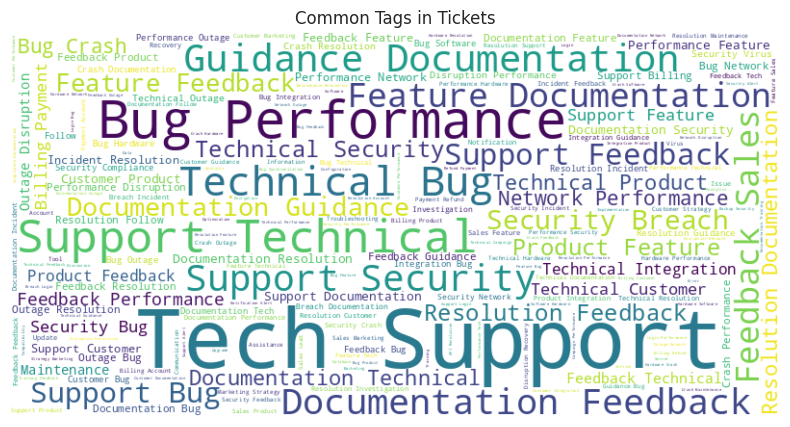

In [ ]:

# 5. Word Cloud of Tags
tags = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']].fillna('').values.flatten()
tags_text = ' '.join(tags)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Tags in Tickets")
plt.show()


<ipython-input-38-321c0d7be8f0>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tags), y=list(counts), palette="coolwarm")


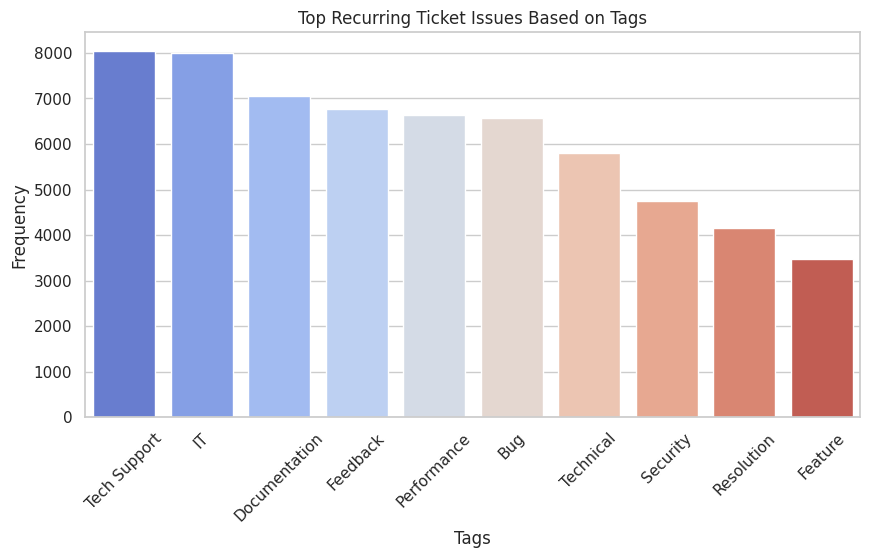

In [ ]:
# Ensure necessary columns exist
#df = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8', 'priority', 'type', 'subject']].fillna('')#
# 6. Top Recurring Ticket Issues Based on Tags
df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']] = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']].fillna('')

all_tags = [tag.strip() for tag in df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']].values.flatten() if tag.strip()]


tag_counts = Counter(all_tags)

top_tags = tag_counts.most_common(10)  # Top 10 tags
tags, counts = zip(*top_tags)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(tags), y=list(counts), palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top Recurring Ticket Issues Based on Tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.show()




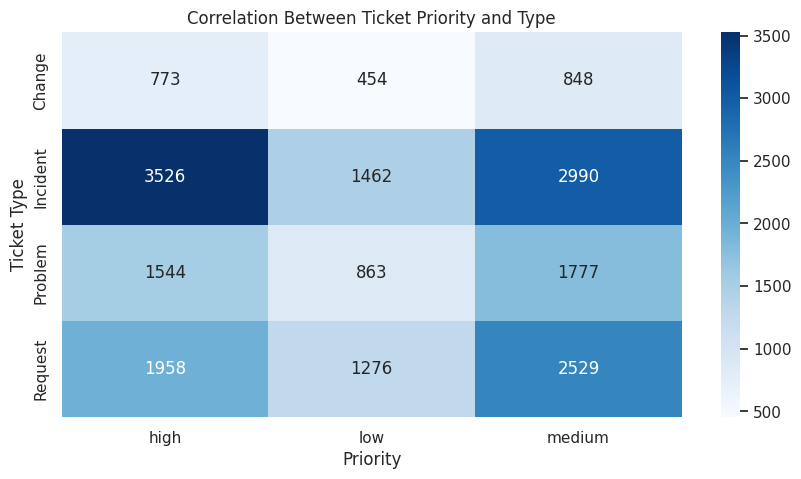

In [ ]:
# 7. Correlation Between Ticket Priority and Type
plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(df['type'], df['priority']), annot=True, cmap="Blues", fmt='d')
plt.title("Correlation Between Ticket Priority and Type")
plt.xlabel("Priority")
plt.ylabel("Ticket Type")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


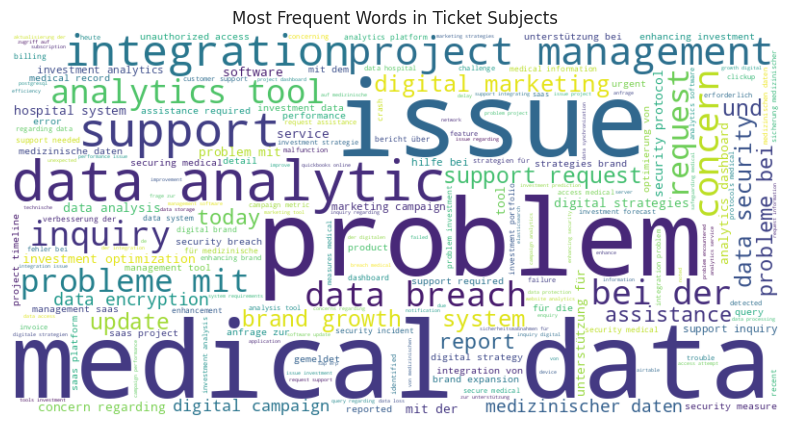

In [ ]:

# 8. Most Frequent Words in Ticket Subjects (Excluding Stopwords)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess and extract words
all_words = " ".join(df['subject'].fillna("").astype(str)).lower().translate(str.maketrans('', '', string.punctuation)).split()

filtered_words = [word for word in all_words if word not in stop_words]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Ticket Subjects")
plt.show()

# New Section

In [ ]:
# Selecting feature columns
feature_columns = ['subject', 'body', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']
target_column = 'queue'

# Handle missing values if any (fill with empty string)
df[feature_columns] = df[feature_columns].fillna('')
df[target_column] = df[target_column].fillna('Unknown')

# Convert text features into string type
df[feature_columns] = df[feature_columns].astype(str)

# Encode categorical text features using Label Encoding
label_encoders = {}
for col in feature_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Encode target variable (queue column)
label_encoder_queue = LabelEncoder()
df[target_column] = label_encoder_queue.fit_transform(df[target_column])

# Define features (X) and target (y)
X = df[feature_columns]
y = df[target_column]

# Split dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
logistic_model = LogisticRegression(max_iter=500, random_state=42)
logistic_model.fit(X_train_scaled, y_train)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_logistic = logistic_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)

# Evaluate accuracy
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Print results
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logistic))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Accuracy: 0.3242
Random Forest Accuracy: 0.3583

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.48      0.43      0.46       417
           1       0.28      0.03      0.05       630
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       458
           5       0.11      0.00      0.01       742
           6       0.00      0.00      0.00       200
           7       0.00      0.00      0.00       114
           8       0.00      0.00      0.00       153
           9       0.31      0.94      0.47      1165

    accuracy                           0.32      4000
   macro avg       0.12      0.14      0.10      4000
weighted avg       0.20      0.32      0.19      4000


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.73     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

# Encode target variable (queue)
df['queue_encoded'] = df['queue'].astype('category').cat.codes
queue_mapping = dict(enumerate(df['queue'].astype('category').cat.categories))

# Combine all relevant text features
# Convert tags to string and combine them
df['tags_combined'] = df[['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']].astype(str).agg(' '.join, axis=1)

# Convert all text columns to string before concatenation
df['text_combined_full'] = df['subject'].astype(str) + " " + df['body'].astype(str) + " " + " " + df['tags_combined']


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['text_combined_full'], df['queue_encoded'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))  # Use n-grams for better context
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')  # Use class weights for imbalance
rf_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=queue_mapping.values()))

Random Forest Accuracy: 0.52375
Classification Report:
                                  precision    recall  f1-score   support

           Billing and Payments       0.84      0.68      0.75       422
               Customer Service       0.42      0.52      0.47       652
                General Inquiry       1.00      0.22      0.36        54
                Human Resources       0.73      0.33      0.46        66
                     IT Support       0.77      0.27      0.40       458
                Product Support       0.46      0.40      0.42       707
          Returns and Exchanges       0.87      0.22      0.35       203
            Sales and Pre-Sales       0.68      0.19      0.30       119
Service Outages and Maintenance       0.57      0.48      0.52       140
              Technical Support       0.49      0.76      0.59      1179

                       accuracy                           0.52      4000
                      macro avg       0.68      0.41      0.46    

In [ ]:
# Function to predict queue for custom input text
def predict_queue(input_text):
    # Preprocess the input text (same as training data)
    input_text_processed = input_text  # No need to combine features here since it's already a single string

    # Transform the input text using the same TF-IDF vectorizer
    input_text_tfidf = vectorizer.transform([input_text_processed])

    # Predict the queue using the trained Random Forest model
    predicted_label = rf_model.predict(input_text_tfidf)[0]

    # Map the predicted label to the queue name
    predicted_queue = queue_mapping[predicted_label]

    return predicted_queue

# Test with custom input text
input_texts = {
    "General Inquiry: I have a general question about your services.",
    "Customer Service: I need assistance with my account.",
    "Technical Support: My server crashed and I need technical help.",
    "Product Support: I am facing issues with your product and need support.",
    "IT Support: There is a problem with my computer's network connection.",
    "Billing and Payments: I have a question about my recent invoice.",
    "Service Outages and Maintenance: The website is down and I cannot access it.",
    "Security: I suspect a security breach in my account.",
    "Change: I want to request a change in my subscription plan.",
    "Incident: There was an unexpected outage in the system.",
    "Technischer Support: Mein Server ist abgestürzt und ich brauche technische Hilfe."
    ,"Verkauf: Ich interessiere mich für Ihr Produkt und möchte mehr über die Preise erfahren.",
    "Vorverkauf: Können Sie mir helfen, das richtige Produkt für meine Bedürfnisse auszuwählen?"
}


for text in input_texts:
    predicted_queue = predict_queue(text)
    print(f"Input Text: '{text}' -> Predicted Queue: {predicted_queue}")

Input Text: 'Security: I suspect a security breach in my account.' -> Predicted Queue: Technical Support
Input Text: 'Incident: There was an unexpected outage in the system.' -> Predicted Queue: Technical Support
Input Text: 'Technischer Support: Mein Server ist abgestürzt und ich brauche technische Hilfe.' -> Predicted Queue: Technical Support
Input Text: 'Service Outages and Maintenance: The website is down and I cannot access it.' -> Predicted Queue: Service Outages and Maintenance
Input Text: 'Billing and Payments: I have a question about my recent invoice.' -> Predicted Queue: Billing and Payments
Input Text: 'Change: I want to request a change in my subscription plan.' -> Predicted Queue: Technical Support
Input Text: 'Vorverkauf: Können Sie mir helfen, das richtige Produkt für meine Bedürfnisse auszuwählen?' -> Predicted Queue: Technical Support
Input Text: 'Verkauf: Ich interessiere mich für Ihr Produkt und möchte mehr über die Preise erfahren.' -> Predicted Queue: Technical Su

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv(r'/content/dataset-tickets-multi-lang-4-20k.csv')

# Selecting feature columns
feature_columns = ['subject', 'body', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']
target_column = 'queue'

# Handle missing values
df[feature_columns] = df[feature_columns].fillna('')
df[target_column] = df[target_column].fillna('Unknown')

# Combine text features
df['text_combined'] = df[feature_columns].astype(str).agg(' '.join, axis=1)

# Encode target variable
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

# Define features (X) and target (y)
X = df['text_combined']
y = df[target_column]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Model 1: LSTM --- #
# Tokenization
max_words = 20000  # Maximum words to keep
max_len = 200  # Max length of sequences
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM model
model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=5, batch_size=32)

# Predictions
lstm_preds = np.argmax(model.predict(X_test_seq), axis=1)
accuracy_lstm = accuracy_score(y_test, lstm_preds)

print(f"LSTM Accuracy: {accuracy_lstm:.4f}")
print("\nClassification Report for LSTM:")
print(classification_report(y_test, lstm_preds))

# --- Model 2: NLP (TF-IDF + Random Forest) --- #
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_preds = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, rf_preds)

print(f"Random Forest (TF-IDF) Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_preds))

# Compare results
best_model = "LSTM" if accuracy_lstm > accuracy_rf else "Random Forest (TF-IDF)"
print(f"\nBest Model: {best_model}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 515ms/step - accuracy: 0.3014 - loss: 1.9437 - val_accuracy: 0.3713 - val_loss: 1.7107
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 240s 480ms/step - accuracy: 0.4027 - loss: 1.6699 - val_accuracy: 0.3837 - val_loss: 1.6839
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 241s 482ms/step - accuracy: 0.4490 - loss: 1.5518 - val_accuracy: 0.3887 - val_loss: 1.6864
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 484ms/step - accuracy: 0.4971 - loss: 1.4095 - val_accuracy: 0.3915 - val_loss: 1.7107
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 266s 492ms/step - accuracy: 0.5578 - loss: 1.2625 - val_accuracy: 0.3783 - val_loss: 1.7994
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step
LSTM Accuracy: 0.3782

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       417
           1       0.27      0.42      0.33       630
           2       0.00      0.00      0.00        53
           3       0.36      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest (TF-IDF) Accuracy: 0.4880

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       417
           1       0.39      0.42      0.40       630
           2       1.00      0.08      0.14        53
           3       0.94      0.24      0.38        68
           4       0.88      0.13      0.22       458
           5       0.49      0.32      0.38       742
           6       0.94      0.09      0.16       200
           7       1.00      0.10      0.18       114
           8       0.84      0.27      0.41       153
           9       0.43      0.87      0.57      1165

    accuracy                           0.49      4000
   macro avg       0.78      0.32      0.36      4000
weighted avg       0.61      0.49      0.45      4000


Best Model: Random Forest (TF-IDF)


In [ ]:
#!pip install transformers tensorflow_text
import pandas as pd
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load dataset
df = pd.read_csv('/content/dataset-tickets-multi-lang-4-20k.csv')

# Feature columns
feature_columns = ['subject', 'body', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8']
target_column = 'queue'

# Handle missing values
df[feature_columns] = df[feature_columns].fillna('')
df[target_column] = df[target_column].fillna('Unknown')

# Combine text features into one
df['text_combined'] = df[feature_columns].astype(str).agg(' '.join, axis=1)

# Encode labels
label_encoder = LabelEncoder()
df['queue_encoded'] = label_encoder.fit_transform(df[target_column])

# Define train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text_combined'], df['queue_encoded'], test_size=0.2, random_state=42, stratify=df['queue_encoded'])

# Convert labels to categorical (One-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input texts
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

# Build BERT-based classification model
def create_bert_model():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # Get the output from BERT model
    bert_output = bert_model(input_ids, attention_mask=attention_mask) # Pass the input tensors directly

    # Use the pooled output (bert_output[1])
    embeddings = bert_output[1]

    x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Create and train model
bert_model = create_bert_model()

bert_model.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=y_train,
    validation_data=({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}, y_test),
    epochs=3,
    batch_size=16
)

# Evaluate model
loss, accuracy = bert_model.evaluate(
    x={'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    y=y_test
)

print(f"BERT Model Accuracy: {accuracy:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

ValueError: Exception encountered when calling layer 'tf_bert_model_4' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tf_bert_model_4' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 128), dtype=int32, sparse=False, name=input_ids>
  • attention_mask=<KerasTensor shape=(None, 128), dtype=int32, sparse=False, name=attention_mask>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False